In [2]:
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

DATA_ROOT = Path.home() / "Library" / "CloudStorage" / "OneDrive-DanmarksTekniskeUniversitet" / "Virk2Vec" / "data"

### Setting up: Bankruptcy ground truth

In [3]:
# load data 
registration_folder = DATA_ROOT / "Tables" / "Registrations"
registration_files = [file for file in os.listdir(registration_folder) if file.endswith('.csv')]
registrations = pd.concat([pd.read_csv(os.path.join(registration_folder, file), index_col=0) for file in registration_files])

# filter status data
targets_all = ['UNDER KONKURS', "TVANGSOPLØST", "OPLØST EFTER KONKURS"]
registrations = registrations.loc[registrations.ChangeType == 'Status']
registrations = registrations.loc[registrations.NewValue.isin(targets_all)]

tvang_registrations = registrations.loc[registrations.NewValue.isin(["UNDER KONKURS"])][['CVR', 'FromDate', 'NewValue']]
u_konkurs_registrations = registrations.loc[registrations.NewValue.isin(["TVANGSOPLØST"])][['CVR', 'FromDate', 'NewValue']]

In [4]:
# assert no intersection between the two status types on CVR. 
intersect = set(tvang_registrations.CVR).intersection(set(u_konkurs_registrations.CVR))
df_bankrupt = pd.concat([tvang_registrations, u_konkurs_registrations]).sort_values('FromDate', ascending=True).drop_duplicates('CVR', keep='first')

# add the opløst efter konkurs
rest = registrations.loc[~registrations.CVR.isin(df_bankrupt.CVR)]
print(len(rest))
rest = rest.loc[rest.NewValue.isin(["OPLØST EFTER KONKURS"])]
print(len(rest))

df_bankrupt = pd.concat([df_bankrupt, rest[['CVR', 'FromDate', 'NewValue']]]).rename(columns={'FromDate': 'bankrupt_date', 'NewValue': 'bankrupt_type'})

21
21


### Setting up: Capital data

In [14]:
folder = DATA_ROOT / "Tables" / "CapitalChanges"
files = [file for file in os.listdir(folder) if file.endswith('.csv')]
capital_all = pd.concat([pd.read_csv(os.path.join(folder, file), index_col=0, lineterminator='\n') for file in files])
capital_all = capital_all.merge(df_bankrupt, on='CVR', how='left').fillna({"bankrupt_type": "NOT_BANKRUPT"})

### Viz 1: Rate as a measure of company value

In [ ]:
#filter out companies that have only one entry 
companies_with_multiple_entries = capital_all.groupby('CVR').filter(lambda x: len(x) > 1).CVR.tolist()
capital = capital_all.loc[capital_all.CVR.isin(companies_with_multiple_entries)]

capital = capital.sort_values('Date', ascending=True)
# group by and get a list of rates for each company
test = capital.groupby('CVR').apply(lambda x: np.array(x['Rate'].tolist())).reset_index().rename(columns={0: 'Rates'})

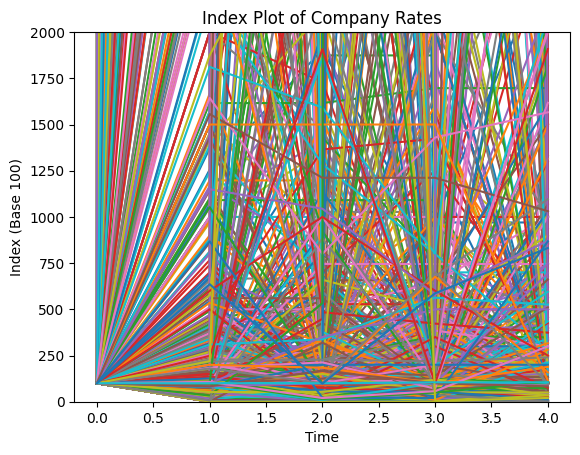

In [48]:
# plot all the rates as a line plot for each line
# Function to normalize a series to start at 100
def normalize_series(series):
    return 100 * series / series[0]

# Apply the normalization to each series in the 'Rates' column
test['NormalizedRates'] = test['Rates'].apply(normalize_series)

# Plot all the normalized rates as a line plot for each company
fig, ax = plt.subplots()
ax.set_ylim(0, 2000)
i = 0
for index, row in test.iterrows():
    if i > 1000:
        break
    

    if len(row['NormalizedRates']) >= 5:
        i += 1
        ax.plot(row['NormalizedRates'][:5])
    

plt.xlabel('Time')
plt.ylabel('Index (Base 100)')
plt.title('Index Plot of Company Rates')
plt.show()

In [54]:
test.merge(df_bankrupt, on='CVR', how='left').fillna({'bankrupt_type':'NOT BANKRUPT'}).bankrupt_type.value_counts()

NOT BANKRUPT            27241
UNDER KONKURS            2292
TVANGSOPLØST              373
OPLØST EFTER KONKURS        1
Name: bankrupt_type, dtype: int64